# KK-2: Engineered features and model comparison

Этот ноутбук добавляет новые инженерные индексы (на базе физико-химических соображений) и сравнивает наборы признаков для прогнозирования `worst_corrosion_rate_mm_per_year` на установке KK-2.


In [3]:
# Импорты и загрузка данных
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns

if '../src' not in sys.path:
    sys.path.append('../src')
from database import load_corrosion_data_new as load_data
from analysis import AdvancedCorrosionAnalyzer

sns.set(style='whitegrid')
TARGET = 'worst_corrosion_rate_mm_per_year'


In [4]:
# Загрузка и фильтрация по установке KK-2
DF_loaded = load_data()
assert TARGET in DF_loaded.columns, f'В данных отсутствует {TARGET}'

DF = DF_loaded[DF_loaded['installation'] == 'KK-2'].copy()
print(f"После фильтрации по 'KK-2': {len(DF):,} строк, {len(DF.columns)} колонок")


После фильтрации по 'KK-2': 11,464 строк, 45 колонок


In [5]:
# Инженерные индексы
import numpy as np

def add_engineered_indices(df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-6
    T0 = 25.0
    kT = 0.025  # температурная чувствительность для CO2 (приближенная)

    df = df.copy()
    # Доступность агрессивных компонентов в водной фазе
    df['h2s_aqueous_exposure'] = df['h2s_content'] * df['h2s_water_ratio'] * df['water_content']
    df['co2_aqueous_temp_index'] = df['co2_content'] * df['water_content'] * np.exp(kT * (df['operating_temperature'] - T0))

    # Кислотная/хлоридная нагрузка в воде
    df['acid_load_aqueous'] = df['total_acidity_index'] * df['water_content']
    df['chloride_aqueous'] = df['chloride_aggressiveness'] * df['water_content']
    df['oxygen_aqueous'] = df['oxygen_content'] * df['water_content']

    # Комбинированные индексы среды/материала/защиты
    df['mixed_acid_gas_index'] = df['h2s_content'] + 0.3 * df['co2_content']
    df['aggressiveness_per_resistance'] = df['corrosion_aggressiveness_index'] / (df['material_resistance_score'] + eps)
    df['protection_gap'] = (df['corrosion_aggressiveness_index'] - df['corrosion_protection_index']).clip(lower=0)
    df['pitting_chloride_index'] = df['pitting_corrosion_index'] * df['chloride_aqueous']

    # Прокси-напряжение и деградация
    df['hoop_stress_proxy'] = df['diameter_to_thickness_ratio'] * df['operating_pressure']
    df['thinning_ratio'] = (df['nominal_thickness_mmc'] - df['worst_thickness_measurement']) / (df['nominal_thickness_mmc'] + eps)
    df['annualized_thinning'] = df['thinning_ratio'] / (df['equipment_age_years'] + eps)
    df['material_adjusted_stress'] = df['stress_corrosion_index'] / (df['material_resistance_score'] + eps)

    return df


In [6]:
# Применяем индексы
DF_enriched = add_engineered_indices(DF)
added_cols = [
    'h2s_aqueous_exposure','co2_aqueous_temp_index','acid_load_aqueous','chloride_aqueous',
    'oxygen_aqueous','mixed_acid_gas_index','aggressiveness_per_resistance','protection_gap',
    'pitting_chloride_index','hoop_stress_proxy','thinning_ratio','annualized_thinning','material_adjusted_stress'
]
print('Добавлены колонки:', added_cols)
DF_enriched[added_cols].describe().T


Добавлены колонки: ['h2s_aqueous_exposure', 'co2_aqueous_temp_index', 'acid_load_aqueous', 'chloride_aqueous', 'oxygen_aqueous', 'mixed_acid_gas_index', 'aggressiveness_per_resistance', 'protection_gap', 'pitting_chloride_index', 'hoop_stress_proxy', 'thinning_ratio', 'annualized_thinning', 'material_adjusted_stress']


,count,mean,std,min,25%,50%,75%,max
h2s_aqueous_exposure,4529.0,9.218795,19.743531,4.000000e-08,0.000019,0.000835,11.138906,6.832676e+01
co2_aqueous_temp_index,3453.0,15676.851254,265300.700615,1.485910e-05,0.001565,0.072517,3.021427,4.507547e+06
acid_load_aqueous,7625.0,1.104319,3.088917,0.000000e+00,0.000000,0.000000,0.003891,3.378024e+01
chloride_aqueous,7625.0,0.083926,0.912273,0.000000e+00,0.000000,0.000000,0.000000,9.999000e+00
oxygen_aqueous,98.0,19.092966,10.230474,5.908572e-02,18.050823,18.050823,29.707615,2.970761e+01
mixed_acid_gas_index,3736.0,1.497790,2.521994,3.500000e-04,0.019120,0.170000,3.479280,9.283420e+00
aggressiveness_per_resistance,11464.0,2.884880,8.997290,0.000000e+00,0.000000,0.000000,0.093500,4.132998e+01
protection_gap,11464.0,5.862660,18.139507,0.000000e+00,0.000000,0.000000,0.187000,8.266000e+01
pitting_chloride_index,7625.0,8.391764,91.218174,0.000000e+00,0.000000,0.000000,0.000000,9.998000e+02
hoop_stress_proxy,11464.0,8.653486,9.306181,0.000000e+00,1.828571,6.327000,12.896250,3.650000e+02



🔬 Тестируем набор: baseline_best
   Признаки: ['wall_thickness', 'cross_sectional_area', 'diameter_to_thickness_ratio', 'inner_diameter', 'outer_diameter', 'nominal_thickness_mmc', 'pitting_corrosion_index', 'underdeposit_corrosion_index', 'stress_corrosion_index', 'corrosion_aggressiveness_index', 'material_resistance_score', 'equipment_age_years', 'component_type_id', 'corrosion_protection_index']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.1063 | MAE =  0.0574 | RMSE =  0.1012
   random_forest   | R² =  0.3475 | MAE =  0.0478 | RMSE =  0.0865

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.3475)

🔬 Тестируем набор: eng_h2s_replaced
   Признаки: ['wall_thickness', 'cross_sectional_area', 'diameter_to_thickness_ratio', 'inner_diameter', 'outer_diameter', 'nominal_thickness_mmc', 'pitting_corrosion_index', 'underdeposit_corrosion_index', 'stress_corrosion_index', 'corrosion_aggressiveness_index', 'material_resistance_score', 'equipment_age_years', 'component_type_id', 'corrosion_protect

<Figure size 1200x600 with 0 Axes>

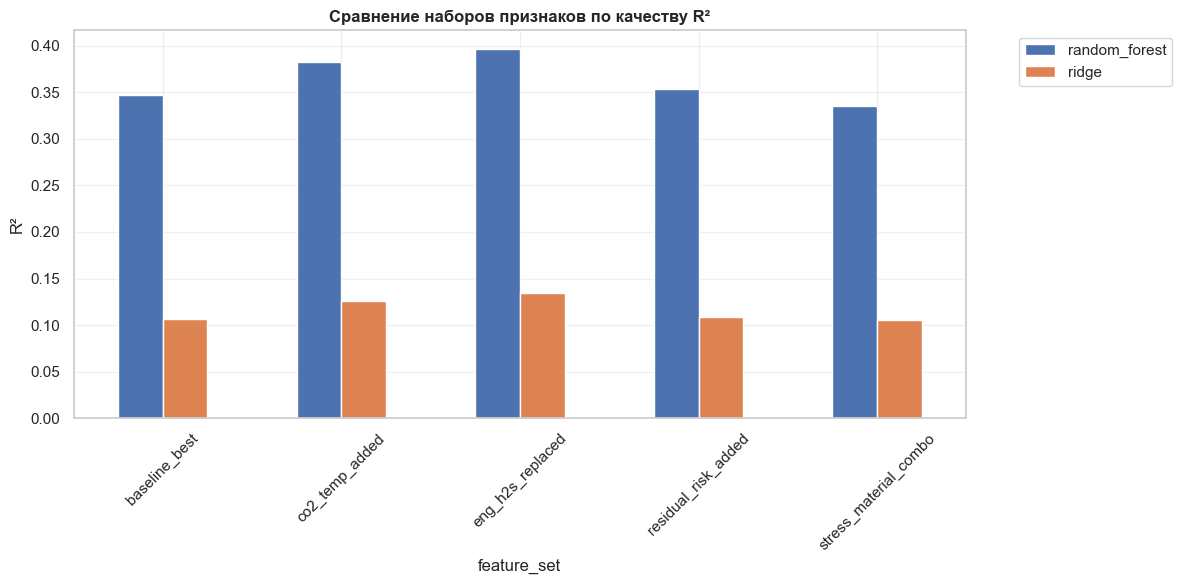

,model,r2,mae,rmse,n_features,n_samples,features,feature_set
0,ridge,0.106265,0.057403,0.101209,14,11464,"wall_thickness, cross_sectional_area, diameter...",baseline_best
1,random_forest,0.347469,0.047844,0.086480,14,11464,"wall_thickness, cross_sectional_area, diameter...",baseline_best
2,ridge,0.134824,0.065225,0.086038,15,4529,"wall_thickness, cross_sectional_area, diameter...",eng_h2s_replaced
3,random_forest,0.396718,0.051873,0.071845,15,4529,"wall_thickness, cross_sectional_area, diameter...",eng_h2s_replaced
4,ridge,0.125891,0.055991,0.079772,15,3453,"wall_thickness, cross_sectional_area, diameter...",co2_temp_added


In [7]:
# Эксперимент: сравнение наборов признаков с новыми индексами
analyzer = AdvancedCorrosionAnalyzer(DF_enriched)
analyzer.set_target(TARGET)

baseline_best = [
    # Геометрия
    'wall_thickness','cross_sectional_area','diameter_to_thickness_ratio',
    'inner_diameter','outer_diameter','nominal_thickness_mmc',
    # Индексы коррозии
    'pitting_corrosion_index','underdeposit_corrosion_index','stress_corrosion_index','corrosion_aggressiveness_index',
    # Материал/возраст/тип
    'material_resistance_score','equipment_age_years','component_type_id',
    # Защита
    'corrosion_protection_index',
]

feature_sets = {
    # Базовый лучший без ops/H2S (ориентир)
    'baseline_best': baseline_best,

    # Замена H2S-блока на «водную экспозицию H2S»
    'eng_h2s_replaced': baseline_best + ['h2s_aqueous_exposure'],

    # Добавление температурно-моделированного CO2 в воде
    'co2_temp_added': baseline_best + ['co2_aqueous_temp_index'],

    # Напряжения и материал
    'stress_material_combo': baseline_best + ['material_adjusted_stress','hoop_stress_proxy'],

    # Остаточный риск/соотношение агрессивности и стойкости
    'residual_risk_added': baseline_best + ['protection_gap','aggressiveness_per_resistance'],

    # Полный набор инженерных индексов
    'full_engineered': baseline_best + [
        'h2s_aqueous_exposure','co2_aqueous_temp_index','acid_load_aqueous','chloride_aqueous','oxygen_aqueous',
        'mixed_acid_gas_index','aggressiveness_per_resistance','protection_gap','pitting_chloride_index',
        'hoop_stress_proxy','thinning_ratio','annualized_thinning','material_adjusted_stress'
    ],
}

comparison = analyzer.compare_feature_sets(feature_sets)
comparison.head()


In [8]:
# Доп. преобразования: логарифмы, клиппинг, взаимодействия
DF_eng2 = DF_enriched.copy()

# log1p трансформации (для скошенных распределений)
log_cols = ['h2s_content','co2_content','water_content','oxygen_content',
            'chloride_aggressiveness','total_acidity_index','total_acids',
            'total_chlorine_compounds','total_sulfur_compounds']
for c in log_cols:
    if c in DF_eng2.columns:
        DF_eng2[f'log1p_{c}'] = np.log1p(DF_eng2[c].clip(lower=0))

# клиппинг по 99-му перцентилю для "тяжёлых хвостов"
clip_cols = ['h2s_aqueous_exposure','co2_aqueous_temp_index','acid_load_aqueous',
             'chloride_aqueous','oxygen_aqueous','hoop_stress_proxy']
for c in clip_cols:
    if c in DF_eng2.columns:
        p99 = DF_eng2[c].quantile(0.99)
        DF_eng2[f'{c}_c'] = DF_eng2[c].clip(upper=p99)

# дополнительные взаимодействия
DF_eng2['temp_x_h2s_aq'] = DF_eng2['operating_temperature'] * DF_eng2['h2s_aqueous_exposure']
DF_eng2['pressure_x_dtt'] = DF_eng2['operating_pressure'] * DF_eng2['diameter_to_thickness_ratio']

# Блоки признаков
GEO = ['wall_thickness','cross_sectional_area','diameter_to_thickness_ratio','inner_diameter','outer_diameter','nominal_thickness_mmc']
INDEXES = ['pitting_corrosion_index','underdeposit_corrosion_index','stress_corrosion_index','corrosion_aggressiveness_index']
MATERIAL = ['material_resistance_score','equipment_age_years','component_type_id']
PROTECTION = ['corrosion_protection_index']
RESIDUAL = ['protection_gap','aggressiveness_per_resistance']
STRESS = ['hoop_stress_proxy','material_adjusted_stress']
THINNING = ['thinning_ratio','annualized_thinning']
AQUEOUS = ['h2s_aqueous_exposure_c','co2_aqueous_temp_index_c','chloride_aqueous_c','oxygen_aqueous_c','acid_load_aqueous_c']
AQUEOUS_RAW = ['h2s_aqueous_exposure','co2_aqueous_temp_index','chloride_aqueous','oxygen_aqueous','acid_load_aqueous']
LOGS = [col for col in DF_eng2.columns if col.startswith('log1p_')]
INTERACT = ['temp_x_h2s_aq','pressure_x_dtt']

print('Готово: добавлены логи, клиппинг и взаимодействия. Кол-во колонок:', len(DF_eng2.columns))


Готово: добавлены логи, клиппинг и взаимодействия. Кол-во колонок: 75


In [9]:
# Исключаем подозрительные (leaky) метрики
LEAKY = [
    'avg_corrosion_rate_mm_per_year',
    'min_corrosion_rate_mm_per_year',
    'worst_thickness_measurement',
    'thinning_ratio',
    'annualized_thinning'
]

cols_to_drop = [c for c in LEAKY if c in DF_eng2.columns]
DF_eng2 = DF_eng2.drop(columns=cols_to_drop)
print('Исключены потенциально утечные признаки:', cols_to_drop)

# Нейтрализуем блок THINNING
THINNING = []



Исключены потенциально утечные признаки: ['avg_corrosion_rate_mm_per_year', 'min_corrosion_rate_mm_per_year', 'worst_thickness_measurement', 'thinning_ratio', 'annualized_thinning']



🔬 Тестируем набор: GEO
   Признаки: ['wall_thickness', 'cross_sectional_area', 'diameter_to_thickness_ratio', 'inner_diameter', 'outer_diameter', 'nominal_thickness_mmc']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0871 | MAE =  0.0585 | RMSE =  0.1023
   random_forest   | R² =  0.2593 | MAE =  0.0539 | RMSE =  0.0921

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.2593)

🔬 Тестируем набор: INDEXES
   Признаки: ['pitting_corrosion_index', 'underdeposit_corrosion_index', 'stress_corrosion_index', 'corrosion_aggressiveness_index']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0252 | MAE =  0.0618 | RMSE =  0.1057
   random_forest   | R² =  0.0879 | MAE =  0.0588 | RMSE =  0.1022

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.0879)

🔬 Тестируем набор: MATERIAL
   Признаки: ['material_resistance_score', 'equipment_age_years', 'component_type_id']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0025 | MAE =  0.0617 | RMSE =  0.1069
   random_forest   | R² =  0.0605 | MAE =  0.0543 | RMSE =  0

<Figure size 1200x600 with 0 Axes>

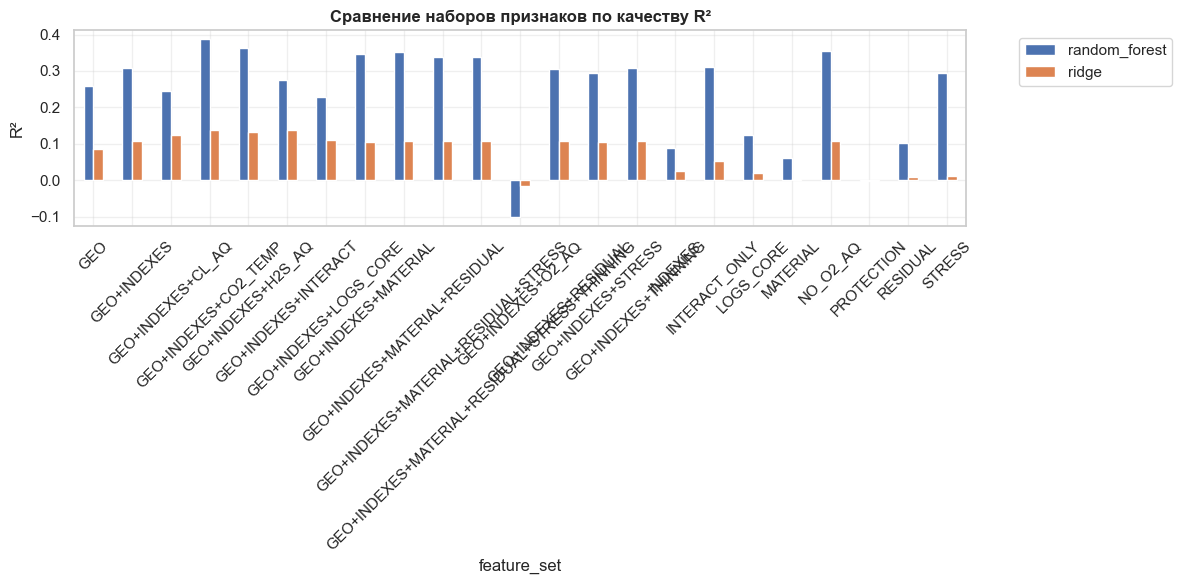

,model,r2,mae,rmse,n_features,n_samples,features,feature_set
0,ridge,0.087056,0.058489,0.102291,6,11464,"wall_thickness, cross_sectional_area, diameter...",GEO
1,random_forest,0.259283,0.053881,0.092138,6,11464,"wall_thickness, cross_sectional_area, diameter...",GEO
2,ridge,0.025151,0.061763,0.105702,4,11464,"pitting_corrosion_index, underdeposit_corrosio...",INDEXES
3,random_forest,0.087917,0.058841,0.102242,4,11464,"pitting_corrosion_index, underdeposit_corrosio...",INDEXES
4,ridge,0.002494,0.061657,0.106923,3,11464,"material_resistance_score, equipment_age_years...",MATERIAL


In [10]:
# Расширенная сетка наборов признаков
analyzer2 = AdvancedCorrosionAnalyzer(DF_eng2)
analyzer2.set_target(TARGET)

feature_sets2 = {
    # Базовые блоки
    'GEO': GEO,
    'INDEXES': INDEXES,
    'MATERIAL': MATERIAL,
    'PROTECTION': PROTECTION,
    'RESIDUAL': RESIDUAL,
    'STRESS': STRESS,
    'THINNING': THINNING,
    'AQUEOUS_RAW': AQUEOUS_RAW,
    'AQUEOUS_CLIPPED': AQUEOUS,
    'LOGS_CORE': ['log1p_h2s_content','log1p_co2_content','log1p_chloride_aggressiveness','log1p_total_acidity_index'],
    'INTERACT_ONLY': INTERACT,

    # Парные и тройные комбинации вокруг геометрии
    'GEO+INDEXES': GEO + INDEXES,
    'GEO+INDEXES+MATERIAL': GEO + INDEXES + MATERIAL,
    'GEO+INDEXES+RESIDUAL': GEO + INDEXES + RESIDUAL,
    'GEO+INDEXES+STRESS': GEO + INDEXES + STRESS,
    'GEO+INDEXES+THINNING': GEO + INDEXES + THINNING,
    'GEO+INDEXES+AQUEOUS_RAW': GEO + INDEXES + AQUEOUS_RAW,
    'GEO+INDEXES+AQUEOUS_CLIPPED': GEO + INDEXES + AQUEOUS,
    'GEO+INDEXES+INTERACT': GEO + INDEXES + INTERACT,

    # Точечные добавки водных индексов
    'GEO+INDEXES+H2S_AQ': GEO + INDEXES + ['h2s_aqueous_exposure_c'],
    'GEO+INDEXES+CO2_TEMP': GEO + INDEXES + ['co2_aqueous_temp_index_c'],
    'GEO+INDEXES+CL_AQ': GEO + INDEXES + ['chloride_aqueous_c'],
    'GEO+INDEXES+O2_AQ': GEO + INDEXES + ['oxygen_aqueous_c'],

    # Более крупные смеси
    'GEO+INDEXES+MATERIAL+RESIDUAL': GEO + INDEXES + MATERIAL + RESIDUAL,
    'GEO+INDEXES+MATERIAL+RESIDUAL+STRESS': GEO + INDEXES + MATERIAL + RESIDUAL + STRESS,
    'GEO+INDEXES+MATERIAL+RESIDUAL+STRESS+THINNING': GEO + INDEXES + MATERIAL + RESIDUAL + STRESS + THINNING,
    'GEO+INDEXES+AQUEOUS_CLIPPED+INTERACT': GEO + INDEXES + AQUEOUS + INTERACT,

    # Абляции от "почти полного" (без опер. признаков напрямую)
    'ENG_FULL_NO_OPS': GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + STRESS + THINNING + AQUEOUS + INTERACT,
    'NO_H2S_AQ': GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + STRESS + THINNING + [c for c in AQUEOUS if c != 'h2s_aqueous_exposure_c'] + INTERACT,
    'NO_CO2_TEMP': GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + STRESS + THINNING + [c for c in AQUEOUS if c != 'co2_aqueous_temp_index_c'] + INTERACT,
    'NO_CL_AQ': GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + STRESS + THINNING + [c for c in AQUEOUS if c != 'chloride_aqueous_c'] + INTERACT,
    'NO_O2_AQ': GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + STRESS + THINNING + [c for c in AQUEOUS if c != 'oxygen_aqueous_c'] + INTERACT,
    'NO_RESIDUAL': GEO + INDEXES + MATERIAL + PROTECTION + STRESS + THINNING + AQUEOUS + INTERACT,
    'NO_STRESS': GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + THINNING + AQUEOUS + INTERACT,
    'NO_THINNING': GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + STRESS + AQUEOUS + INTERACT,
    'NO_PROTECTION': GEO + INDEXES + MATERIAL + RESIDUAL + STRESS + THINNING + AQUEOUS + INTERACT,
    'NO_MATERIAL': GEO + INDEXES + PROTECTION + RESIDUAL + STRESS + THINNING + AQUEOUS + INTERACT,

    # С лог-признаками
    'GEO+INDEXES+LOGS_CORE': GEO + INDEXES + ['log1p_h2s_content','log1p_co2_content','log1p_chloride_aggressiveness','log1p_total_acidity_index'],
    'ENG_FULL_NO_OPS+LOGS': (GEO + INDEXES + MATERIAL + PROTECTION + RESIDUAL + STRESS + THINNING + AQUEOUS + INTERACT
                              + ['log1p_h2s_content','log1p_co2_content','log1p_chloride_aggressiveness','log1p_total_acidity_index']),
}

comparison2 = analyzer2.compare_feature_sets(feature_sets2)
comparison2.head()
